In [1]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import scipy

In [ ]:
import astropy.constants as con
import astropy.units as u
import scipy.special
import scipy
import ugradio

In [2]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.linewidth'] = 1

In [24]:
sun_data_1hr, sun_times_1hr = np.load('data/1hr_Sun_data.npy')
sun_data_1hr = sun_data_1hr[50:]
sun_times_1hr = sun_times_1hr[50:]

In [25]:
crab_data, times = np.load('data/final_data.npy')

In [26]:
crab_data.shape

(190401,)

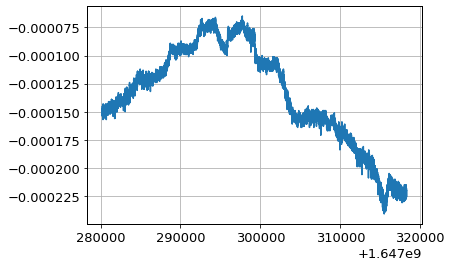

In [27]:
plt.plot(times, crab_data)

In [28]:
plt.figure(figsize=(8,4))
plt.plot(sun_times, sun_data)

NameError: name 'sun_times' is not defined

<Figure size 576x288 with 0 Axes>

In [ ]:
plt.plot(sun_times[:5000], sun_data[:5000])

In [ ]:
n = len(sun_data)
beginning, beginning_time = sun_data[:n//3], sun_times[:n//3]
middle, middle_time = sun_data[n//3:2*n//3], sun_times[n//3:2*n//3]
end, end_time = sun_data[2*n//3:], sun_times[2*n//3:]
beginning_fft = np.fft.fft(beginning)
plt.plot(beginning_fft)

In [3]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr, dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr), dt))

In [4]:
def split_data(data, time, num_splits):
    n = len(data)
    split_size = n // num_splits
    data_splits = []
    freq_splits = []
    for i in range(num_splits):
        data_frac = data[i*split_size:(i+1)*split_size]
        time_frac = time[i*split_size:(i+1)*split_size]
        dt = np.mean(np.diff(time_frac))
        frequency = freq(time_frac, dt)
        pow_frac = pow_fft(data_frac)
        
        data_splits.append(pow_frac)
        freq_splits.append(frequency)
        
    return data_splits, freq_splits

Text(0.5, 1.0, 'Sun 3 Split Power Spectra')

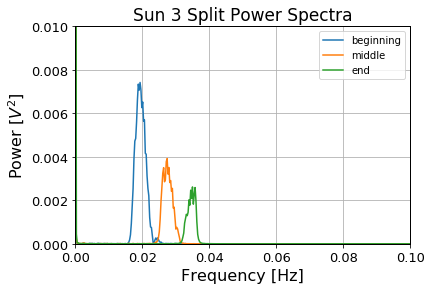

In [110]:
# dt = np.mean(np.diff(sun_times))
# beginning_freq = freq(beginning_time, dt)
# middle_freq = freq(middle_time, dt)
# end_freq = freq(end_time, dt)

# pow_beginning = pow_fft(beginning)
# pow_middle = pow_fft(middle) 
# pow_end = pow_fft(end) 
sun_data_split, sun_time_split = split_data(sun_data, sun_times, 3)
pow_beginning, pow_middle, pow_end = sun_data_split
beginning_freq, middle_freq, end_freq = sun_time_split

plt.plot(beginning_freq, pow_beginning, label="beginning")
plt.plot(middle_freq, pow_middle, label='middle')
plt.plot(end_freq, pow_end, label='end')
plt.legend()
# plt.xlim(0.03,0.04)
plt.xlim(0.0,0.1)
# plt.yscale('log')
plt.ylim(0,0.01)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [$V^2$]')
plt.title('Sun 3 Split Power Spectra')

# should be power squared arbitrary units

In [42]:
val = con.c / (10.5e9 * u.Hz)
λ = val.to(u.m).value
# print("lambda", λ)

L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 

jds=ugradio.timing.julian_date(sun_times)
alpha,delta =ugradio.coord.sunpos(jds[0])
delta=(np.pi/180)*delta
LSTs = ugradio.timing.lst(jds,lon=long)
hs = LSTs - alpha*(np.pi/180)
frac_time = len(sun_times)/23964
ha = np.linspace(hs[0],(hs[0]+(15*6*frac_time)*(np.pi/180)),len(jds))

NameError: name 'con' is not defined

(0, 0.01)

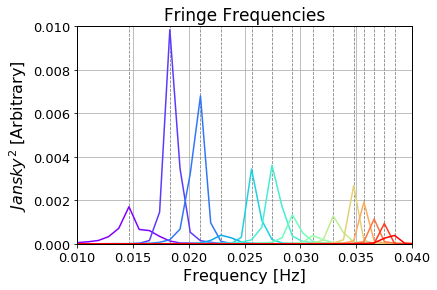

In [79]:
import matplotlib.cm as cm
import scipy.signal

sun_splits, sun_freqs = split_data(sun_data, sun_times, 14)
colors = cm.rainbow(np.linspace(0, 1, len(sun_splits)))
n = len(sun_splits)
peaks = []
ha_peaks = []
for i in range(n):
#     plt.plot(sun_freqs[i], sun_splits[i], color=colors[i], label=str(ha[n * i]))
    plt.plot(sun_freqs[i], sun_splits[i], color=colors[i])
    peak1, peak2 = scipy.signal.find_peaks(sun_splits[i], height=[0.0001, 0.01])[0][0], scipy.signal.find_peaks(sun_splits[i], height=[0.0001, 0.01])[0][-1]
    peaks.append(sun_freqs[i][peak2])
    peaks.append(sun_freqs[i][peak1])
    ha_peaks.append(ha[n * i])
#     plt.vlines(sun_freqs[i][peak1], 0, 0.01, lw=0.5)
    plt.vlines(sun_freqs[i][peak2], 0, 0.01, color='gray',lw=0.8, ls='--')
# plt.legend(loc='upper right')
plt.xlabel("Frequency [Hz]")
plt.ylabel("$Jansky^2$ [Arbitrary]")
plt.title("Fringe Frequencies")
# plt.title("Fringe Frequency")
plt.xlim(0.01,0.04)
plt.ylim(0,0.01)


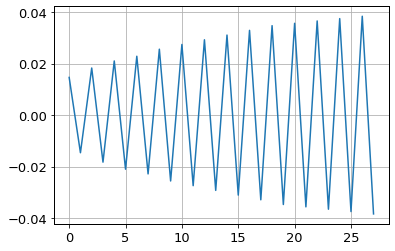

In [82]:
plt.plot(ha_peaks, peaks)

In [42]:
crab_12_data, crab_12_time = np.load('data/final_data.npy')

Text(0, 0.5, 'Power [Arbitrary]')

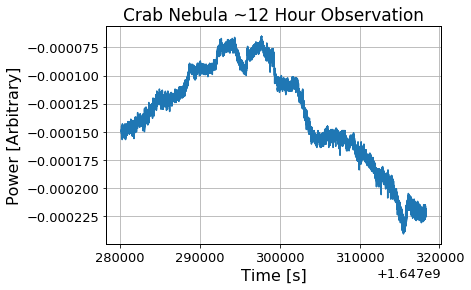

In [43]:
plt.plot(crab_12_time, crab_12_data)
plt.title('Crab Nebula ~12 Hour Observation')
plt.xlabel('Time [s]')
plt.ylabel('Power [Arbitrary]')

Text(0.5, 1.0, 'Crab Nebula 5 Split Power Spectra')

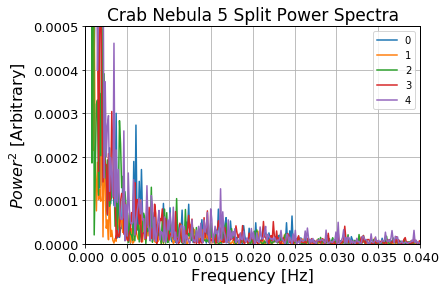

In [44]:
crab_splits, crab_freqs = split_data(crab_12_data, crab_12_time, 5)
for i in range(len(crab_splits)):
#     crab_splits[i][len(crab_splits[i])//2-1000:len(crab_splits[i])//2+1000] = 0
    plt.plot(crab_freqs[i], crab_splits[i], label=str(i))
plt.legend()
plt.xlim(0,0.04)
plt.ylim(0,.0005)
# plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('$Power^2$ [Arbitrary]')
plt.title('Crab Nebula 5 Split Power Spectra')

In [45]:
# should set dt = 1s instead of 0.1s


In [135]:
moon_data, moon_times = np.load('data/moon.npy')

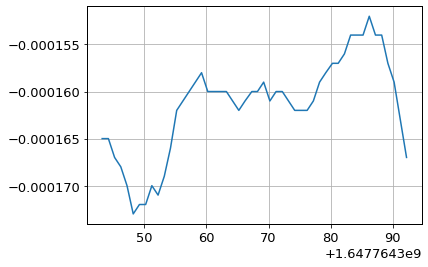

In [136]:
plt.plot(moon_times[:50], moon_data[:50])

Text(0.5, 1.0, 'Split Power Spectra')

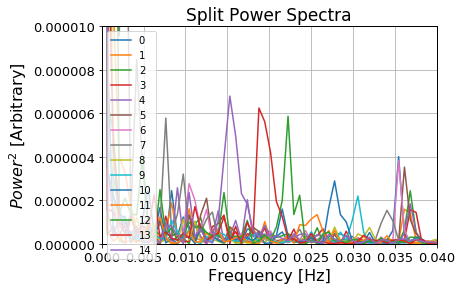

In [137]:
moon_splits, moon_freqs = split_data(moon_data, moon_times, 15)
for i in range(len(moon_splits)):
#     crab_splits[i][len(crab_splits[i])//2-1000:len(crab_splits[i])//2+1000] = 0
    plt.plot(moon_freqs[i], moon_splits[i], label=str(i))
plt.legend(loc='upper left')
plt.xlim(0,0.04)
plt.ylim(0,.00001)
# plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('$Power^2$ [Arbitrary]')
plt.title('Split Power Spectra')

In [5]:
sun_data, sun_times = np.load('data/sun_6hr.npy')
print(len(sun_times), min(sun_times), max(sun_times))

23964 1647962845.7619097 1647984412.4624336


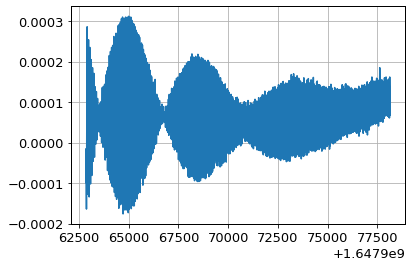

In [11]:
plt.plot(sun_times[:17000], sun_data[:17000])
sun_times, sun_data = sun_times[:17000], sun_data[:17000]
# sun_data[:2000]

In [17]:
import astropy.constants as con
import astropy.units as u
import scipy.special
import scipy
import ugradio

In [18]:
x = np.linspace(0.01,15,10000)
j1 = scipy.special.j1(x)

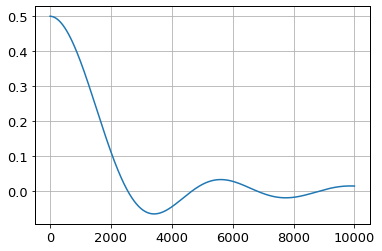

In [19]:
plt.plot(j1/x)

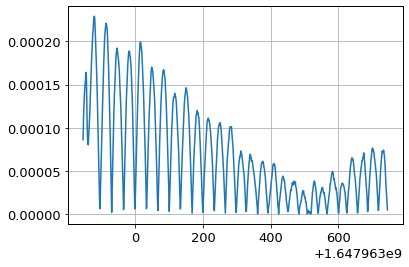

In [20]:
centered_abs_sun_data = np.abs(sun_data - np.average(sun_data))
plt.plot(sun_times[:1000], centered_abs_sun_data[:1000])

(-0.1, 0.1)

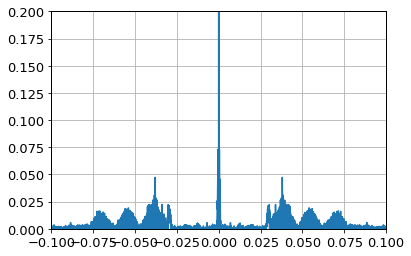

In [21]:
fft = np.fft.fftshift(np.fft.fft(centered_abs_sun_data))
freqs = freq(sun_times, np.mean(np.diff(sun_times)))
plt.plot(freqs, fft)
plt.ylim(0,.2)
plt.xlim(-0.1, 0.1)
# plt.vlines(0.2, 0, .2)

(-0.025, 0.025)

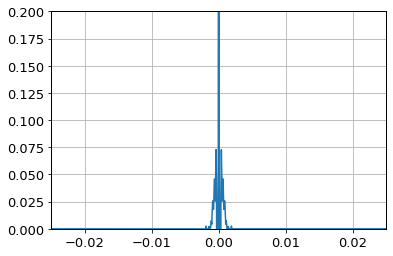

In [22]:
fft[np.where(freqs > 0.002)] = 0
fft[np.where(freqs < -0.002)] = 0
plt.plot(freqs, fft)
plt.ylim(0,0.2)
plt.xlim(-0.025, 0.025)

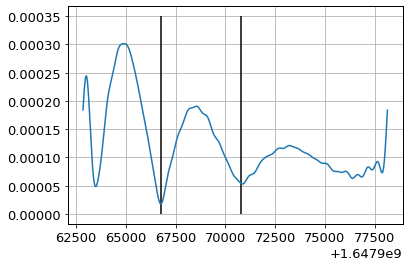

In [23]:
filtered_sun_data = np.fft.ifft(fft)
centered_abs_filtered = np.abs(filtered_sun_data - np.average(filtered_sun_data))
plt.plot(sun_times[:20000], 2*centered_abs_filtered[:20000])
# plt.plot(sun_times[:10000], (sun_data - np.median(sun_data))[:10000])
# np.where(sun_times < )
# plt.xlim(65000+1.6479e9, 72500+1.6479e9)
plt.vlines(66750+1.6479e9, 0,0.00035)
plt.vlines(70800+1.6479e9, 0, 0.00035)


(1647965000.0, 1647972500.0)

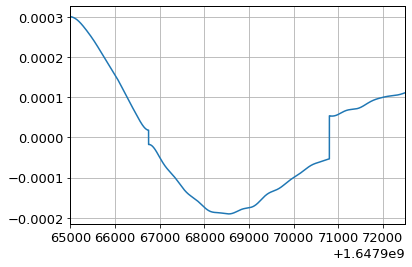

In [24]:
centered_abs_filtered[np.where((sun_times < 70800+1.6479e9) & (sun_times > 66750+1.6479e9))] *= -1
plt.plot(sun_times[:20000], 2*centered_abs_filtered[:20000])
plt.xlim(65000+1.6479e9, 72500+1.6479e9)

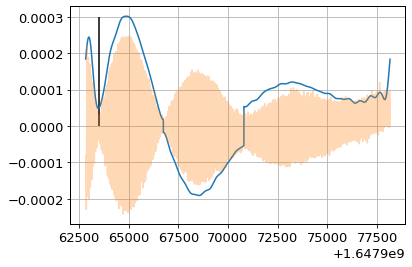

In [25]:
plt.plot(sun_times[:20000], 2*centered_abs_filtered[:20000])
plt.plot(sun_times[:20000], (sun_data - np.average(sun_data))[:20000], alpha=0.3)
plt.vlines(63500+1.6479e9, 0, 0.0003)
sun_data = sun_data[np.where(sun_times < 75000+1.6479e9)]
centered_abs_filtered = centered_abs_filtered[np.where(sun_times < 75000+1.6479e9)]
sun_times = sun_times[np.where(sun_times < 75000+1.6479e9)]
sun_data = sun_data[np.where(sun_times > 63500+1.6479e9)]
centered_abs_filtered = centered_abs_filtered[np.where(sun_times > 63500+1.6479e9)]
sun_times = sun_times[np.where(sun_times > 63500+1.6479e9)]

Text(0, 0.5, 'Jansky [Arbitrary]')

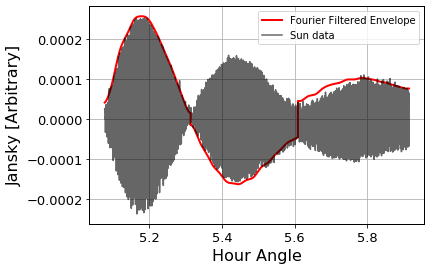

In [115]:
val = con.c / (10.5e9 * u.Hz)
λ = val.to(u.m).value
# print("lambda", λ)

L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 

jds=ugradio.timing.julian_date(sun_times)
alpha,delta =ugradio.coord.sunpos(jds[0])
delta=(np.pi/180)*delta
LSTs = ugradio.timing.lst(jds,lon=long)
hs = LSTs - alpha*(np.pi/180)
frac_time = len(sun_times)/23964
ha = np.linspace(hs[0],(hs[0]+(15*6*frac_time)*(np.pi/180)),len(jds))
# print(ha[1])


plt.plot(ha, 1.7*centered_abs_filtered, 'r-', lw=2,label="Fourier Filtered Envelope")
plt.plot(ha, sun_data - np.average(sun_data), 'k', alpha=0.6, label="Sun data")
plt.legend()
plt.xlabel('Hour Angle')
plt.ylabel('Jansky [Arbitrary]')
# print(len(sun_times), len(sun_times)/23964)

In [89]:
def bessel(ha, thetaR, A):
#     delta = 0
    d = 14.7106 #m 14.7106 or 14.8806
    u = d * np.cos(delta) * np.cos(ha) / λ
    x = 2 * np.pi * thetaR * u
    return A * scipy.special.j1(x) / x

In [90]:
p0 = [0.0046, 0.1]
pars, cov = scipy.optimize.curve_fit(bessel, ha, centered_abs_filtered, p0)

In [91]:
print(pars)

[ 0.0038801  -0.00226802]


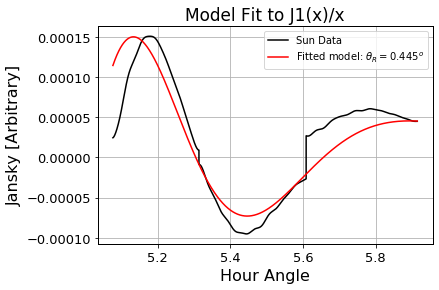

In [116]:
plt.plot(ha, centered_abs_filtered, 'k', label='Sun Data')
plt.plot(ha, bessel(ha, pars[0], pars[1]), 'r-', label=r'Fitted model: $\theta_{R} = 0.445^o$')
plt.title('Model Fit to J1(x)/x')
plt.xlabel('Hour Angle')
plt.ylabel('Jansky [Arbitrary]')
plt.legend()

In [87]:
sun_diameter = pars[0] * 180 / np.pi 
print('sun diameter:', sun_diameter) 
print('Percent of expected value:', sun_diameter/0.53 * 100)
# expected 0.53 degrees

sun diameter: 0.4445960135217065
Percent of expected value: 83.88604028711444


In [ ]:
# .0039 radians is the radius